In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

### Load data 

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=12.6s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load score 

In [5]:
SCORE_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file'
DIC_SCORE_PATH={'1en2':join(SCORE_PATH,'score.facs.gwas_max_abs_z.top500'),
                '1en3':join(SCORE_PATH,'score.facs.gwas_max_abs_z.top500.weight_1en3')}
VERSION_LIST=list(DIC_SCORE_PATH.keys())

dic_trait_list = {x:[] for x in DIC_SCORE_PATH.keys()}
dic_score = {}

for version in DIC_SCORE_PATH.keys():

    SCORE_PATH=DIC_SCORE_PATH[version]
    df_score = None
    for file in [x for x in os.listdir(SCORE_PATH) if '.score.gz' in x]:
        trait = file.replace('.score.gz','')
        dic_trait_list[version].append(trait)
        temp_df = pd.read_csv(join(SCORE_PATH,file), sep='\t', index_col=0)
        temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
        temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]

        if df_score is None:
            df_score = temp_df.copy()
        else:
            df_score = pd.concat([df_score, temp_df], axis=1)
    dic_score[version] = df_score.copy()        

In [6]:
df_score = dic_score['1en2']
trait_list = sorted(list(set(dic_trait_list['1en2'])))

### Add overall association patterns 

### Zonation? 

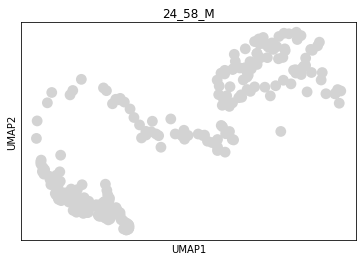

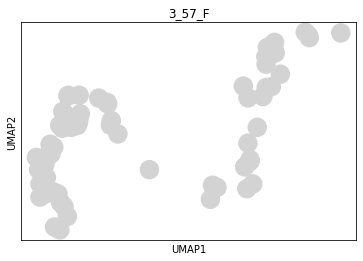

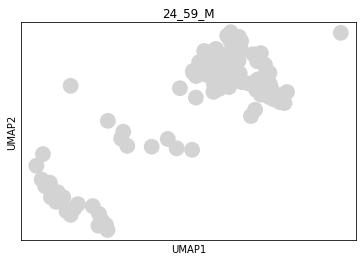

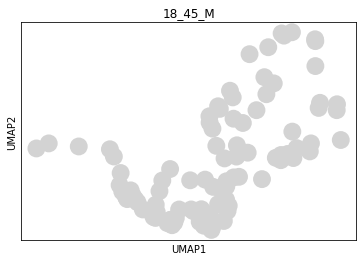

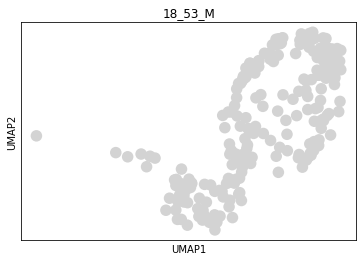

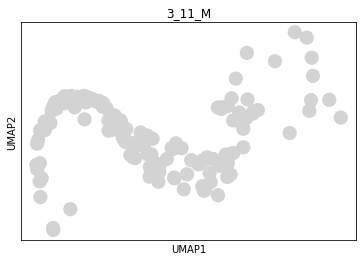

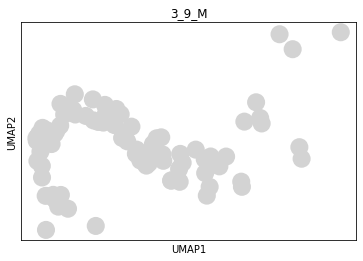

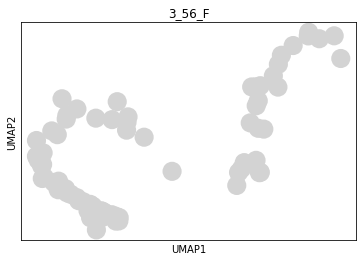

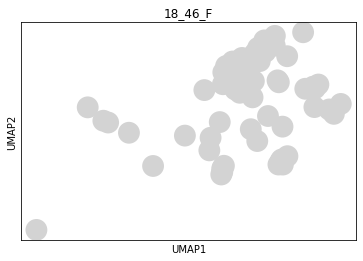

In [20]:
tissue='Liver'
for mouse_id in set(dic_data_facs[tissue].obs['mouse.id']):
    
    adata_small = dic_data_facs[tissue][(dic_data_facs[tissue].obs['cell_ontology_class']=='hepatocyte') & 
                                        (dic_data_facs[tissue].obs['mouse.id']==mouse_id) ]
    sc.pl.umap(adata_small, title=mouse_id)

In [28]:
gene_list = ['Glul', 'Apoe', 'Cyp1a2', 'Cyp2e1', 'Cyp2f2', 'Alb', 'Pck1']
for gene in gene_list: 
    if gene not in data_facs_ct.var_names:
        print(gene)

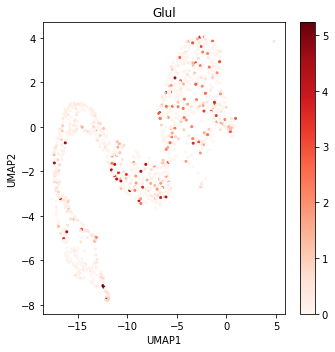

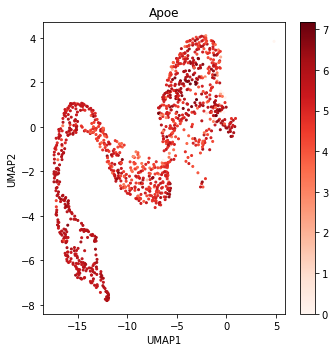

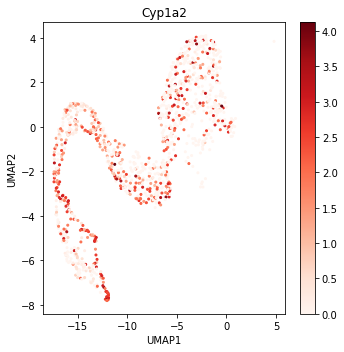

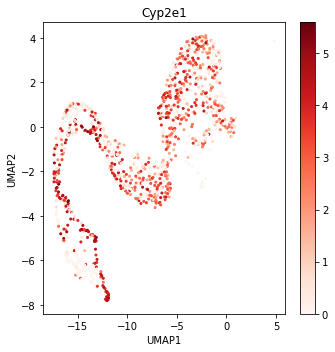

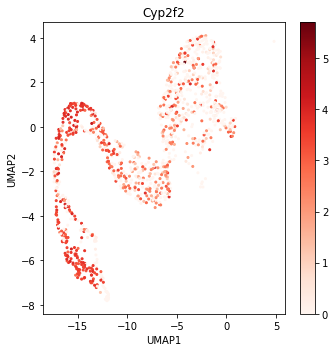

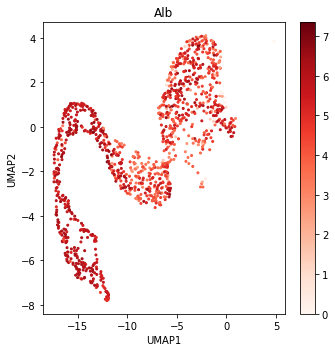

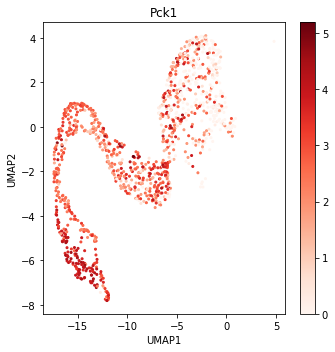

In [31]:
adata_small = data_facs_ct[data_facs_ct.obs['tissue_celltype']=='Liver.hepatocyte'].copy()
cell_list = list(adata_small.obs.index)

df_plot = pd.DataFrame(index=cell_list,
                       data={x:adata_small[:,x].X.toarray().reshape([-1]) for x in gene_list})
df_umap = pd.DataFrame(index=dic_data_facs[tissue].obs.index,
                       data={'UMAP1':dic_data_facs[tissue].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_facs[tissue].obsm['X_umap'][:,1]})
df_plot = df_plot.join(df_umap)

for gene in gene_list:
    
    plt.figure(figsize=[5,5])
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene],
                cmap='Reds', s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%gene)
    plt.tight_layout()
    plt.show()

In [70]:
# Diffusion map 
# adata = data_facs_ct[data_facs_ct.obs['tissue_celltype']=='Liver.hepatocyte'].copy()
adata = dic_data_facs['Liver'][dic_data_facs['Liver'].obs['cell_ontology_class']=='hepatocyte'].copy()
# sc.pp.filter_genes(adata, min_cells=20)
# sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
# sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
# sc.pp.neighbors(adata, n_neighbors=20)
# sc.tl.umap(adata)
sc.tl.diffmap(adata)

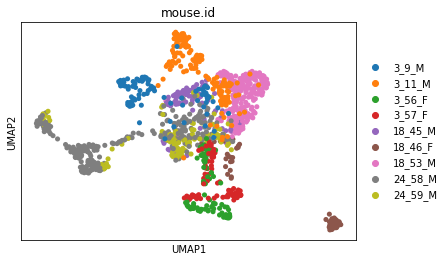

In [64]:
sc.pl.umap(adata, color='mouse.id')

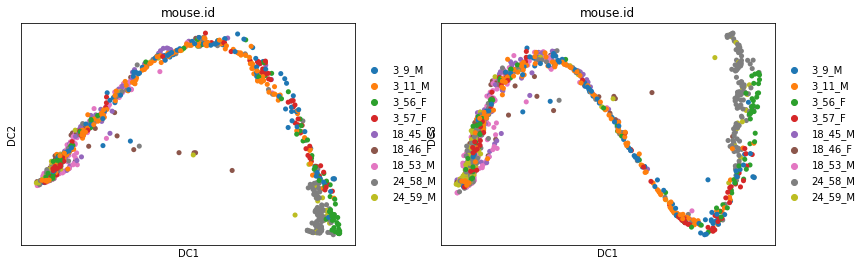

In [71]:
sc.pl.diffmap(adata, color='mouse.id', components=['1,2','1,3'])

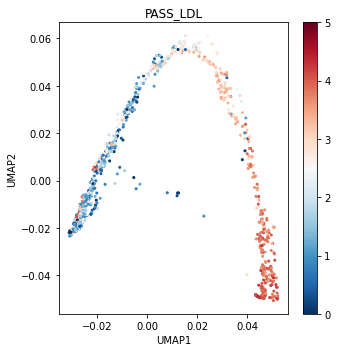

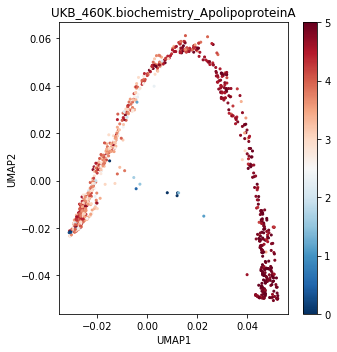

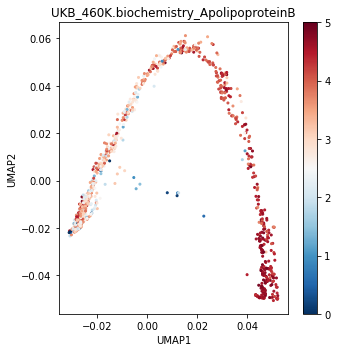

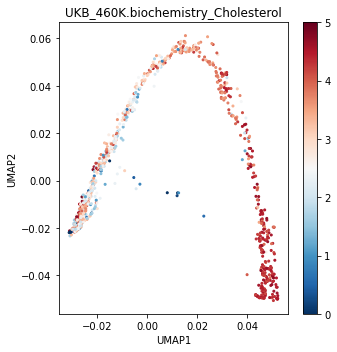

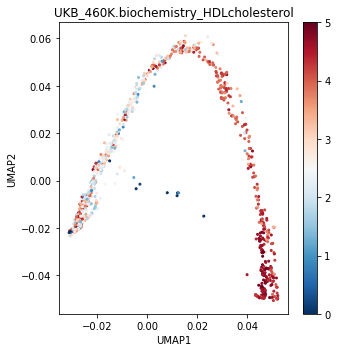

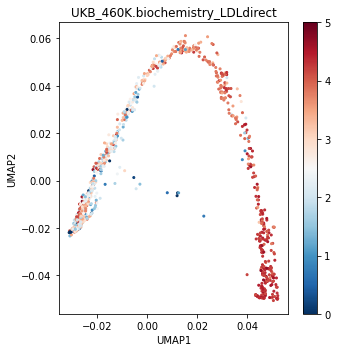

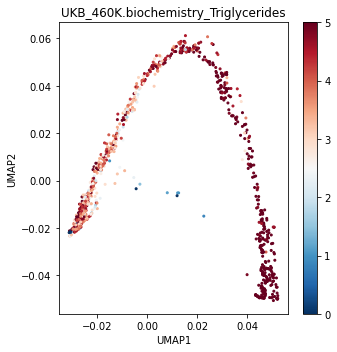

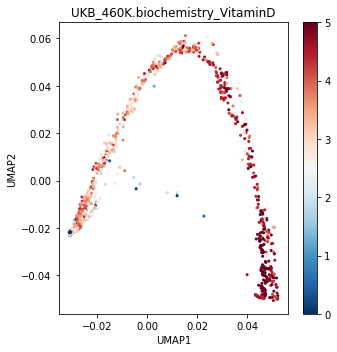

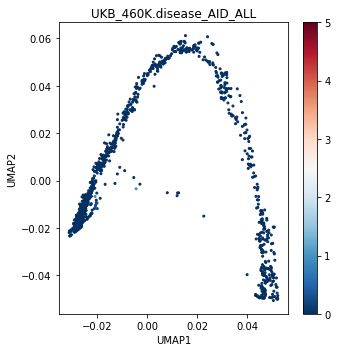

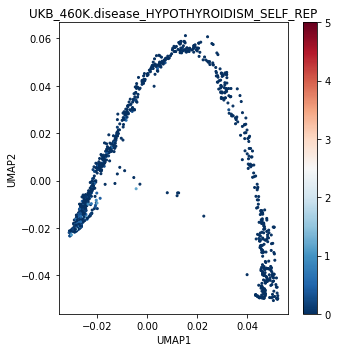

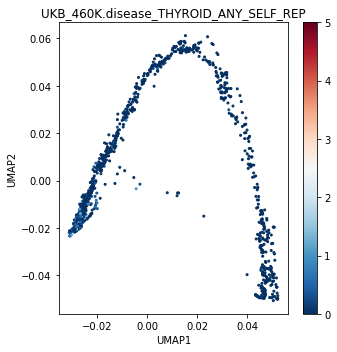

In [73]:
cell_list = list(adata.obs.index)
for trait in trait_plot_list:
    df_plot = pd.DataFrame(index=cell_list,
                           data={'DC1':adata.obsm['X_diffmap'][:,1],
                                 'DC2':adata.obsm['X_diffmap'][:,2],
                                 'zsc':df_score.loc[cell_list, '%s.zscore'%trait].values})
    
    plt.figure(figsize=[5,5])
    max_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.99)
    min_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.01)
    plt.scatter(df_plot['DC1'], df_plot['DC2'], c=df_plot['zsc'],
                cmap='RdBu_r', vmax=5, vmin=0, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%trait)
    plt.tight_layout()
    plt.show()

### Analysis 

In [21]:
dic_data_facs.keys()

dict_keys(['Aorta', 'BAT', 'Bladder', 'Brain_Myeloid', 'Brain_Non-Myeloid', 'Diaphragm', 'GAT', 'Heart', 'Kidney', 'Large_Intestine', 'Limb_Muscle', 'Liver', 'Lung', 'MAT', 'Mammary_Gland', 'Marrow', 'Pancreas', 'SCAT', 'Skin', 'Spleen', 'Thymus', 'Tongue', 'Trachea'])

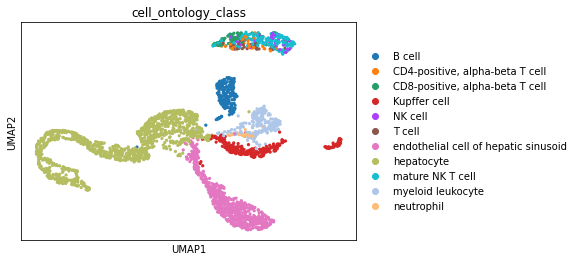

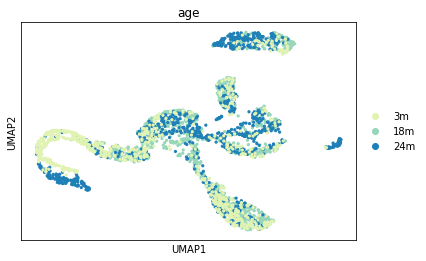

PASS_LDL 185
UKB_460K.biochemistry_ApolipoproteinA 947
UKB_460K.biochemistry_ApolipoproteinB 625
UKB_460K.biochemistry_Cholesterol 544
UKB_460K.biochemistry_HDLcholesterol 582
UKB_460K.biochemistry_LDLdirect 545
UKB_460K.biochemistry_Triglycerides 941
UKB_460K.biochemistry_VitaminD 699
UKB_460K.disease_AID_ALL 98
UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 95
UKB_460K.disease_THYROID_ANY_SELF_REP 64


In [22]:
tissue='Liver'
sc.pl.umap(dic_data_facs[tissue], color='cell_ontology_class')
sc.pl.umap(dic_data_facs[tissue], color='age')
cell_list = list(dic_data_facs[tissue].obs.index)

# Interesting traits 
trait_plot_list = []
for trait in trait_list:
    v_fdr = df_score.loc[cell_list, '%s.fdr'%trait].values
    if (v_fdr<0.05).sum()>50:
        print(trait, (v_fdr<0.05).sum())
        trait_plot_list.append(trait)

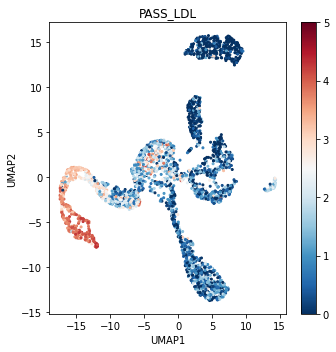

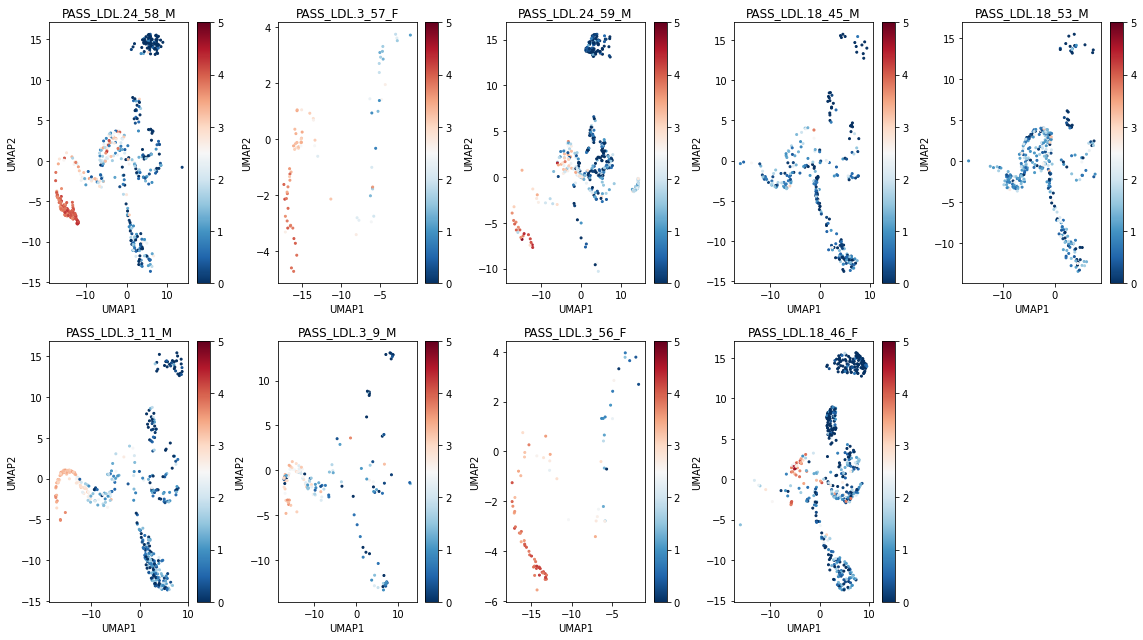

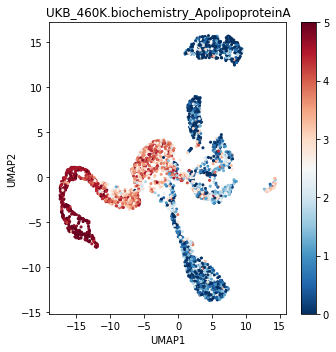

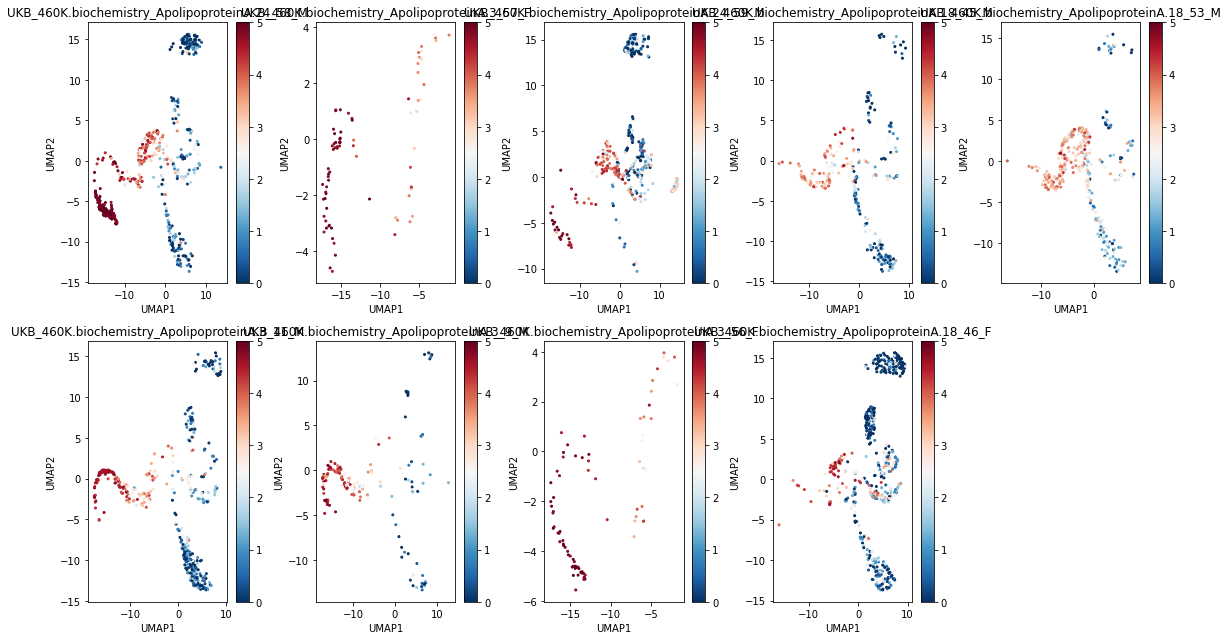

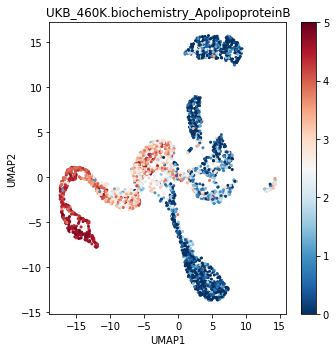

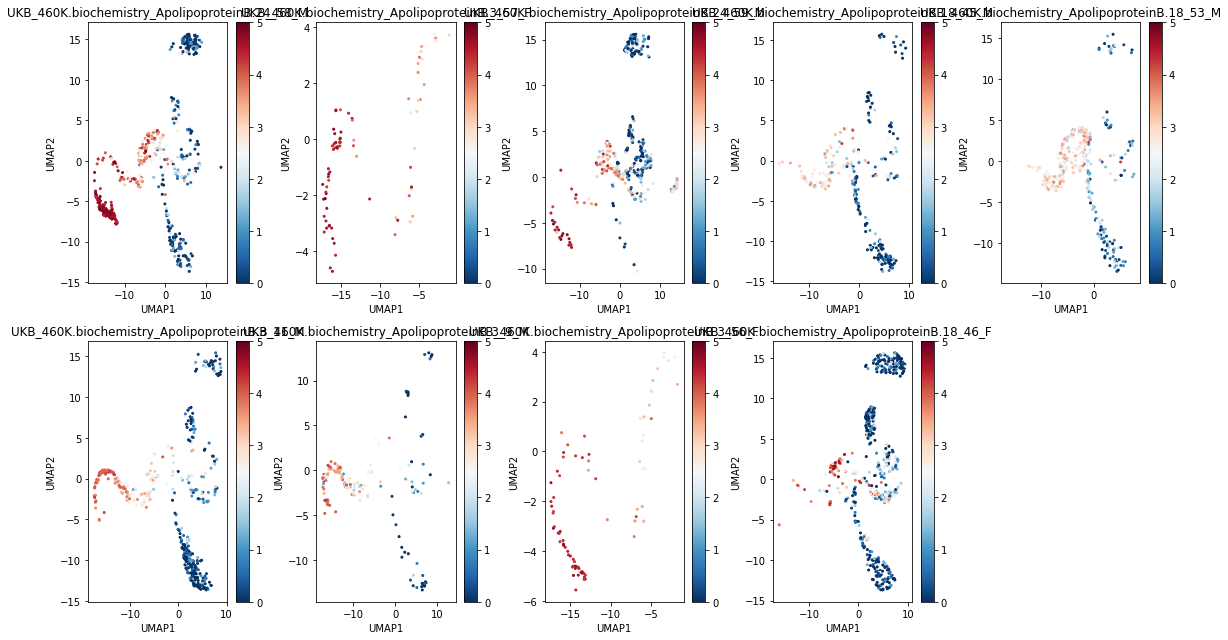

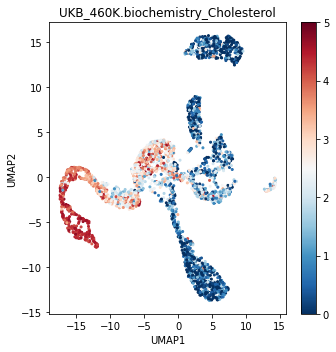

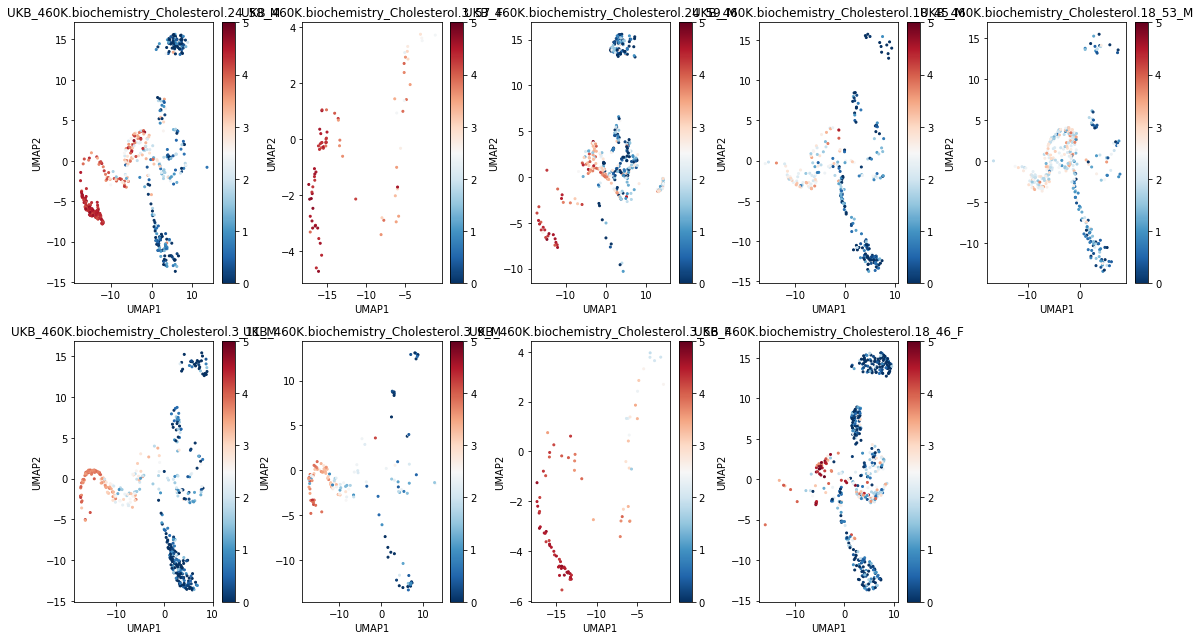

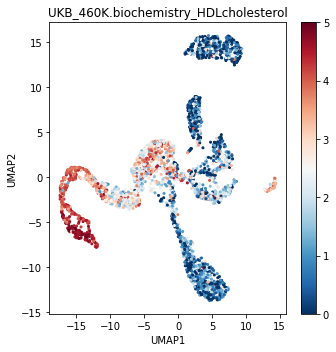

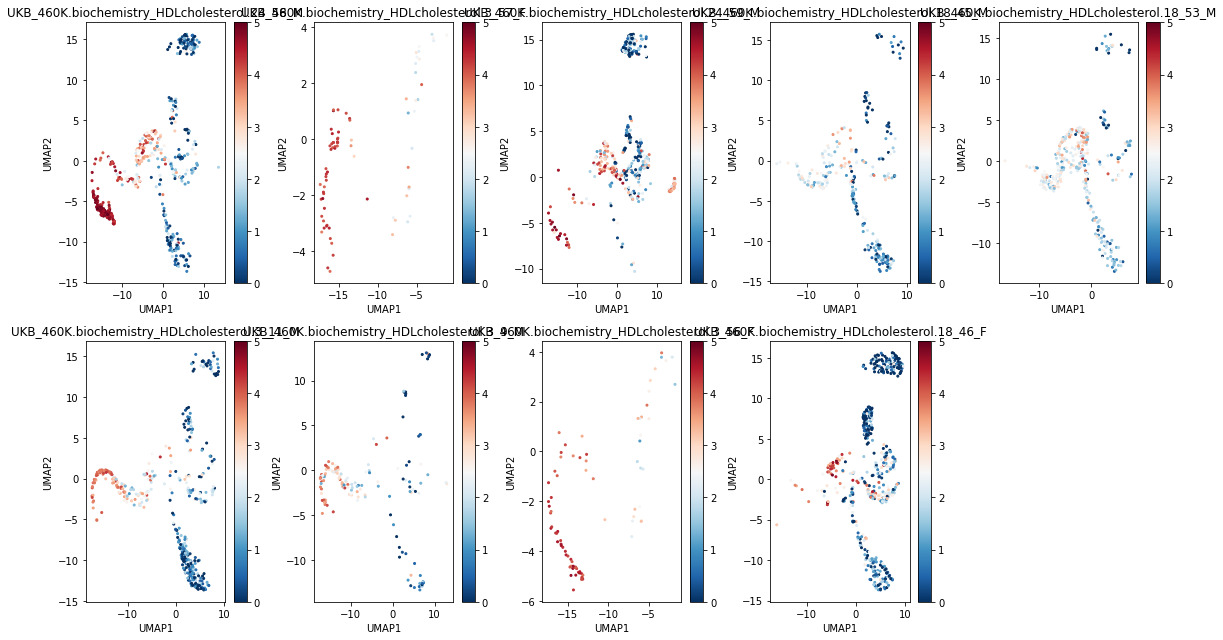

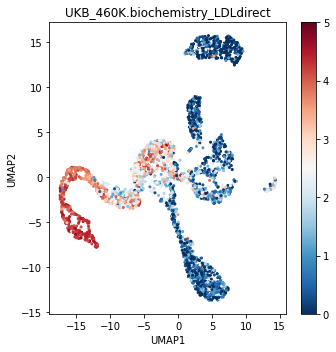

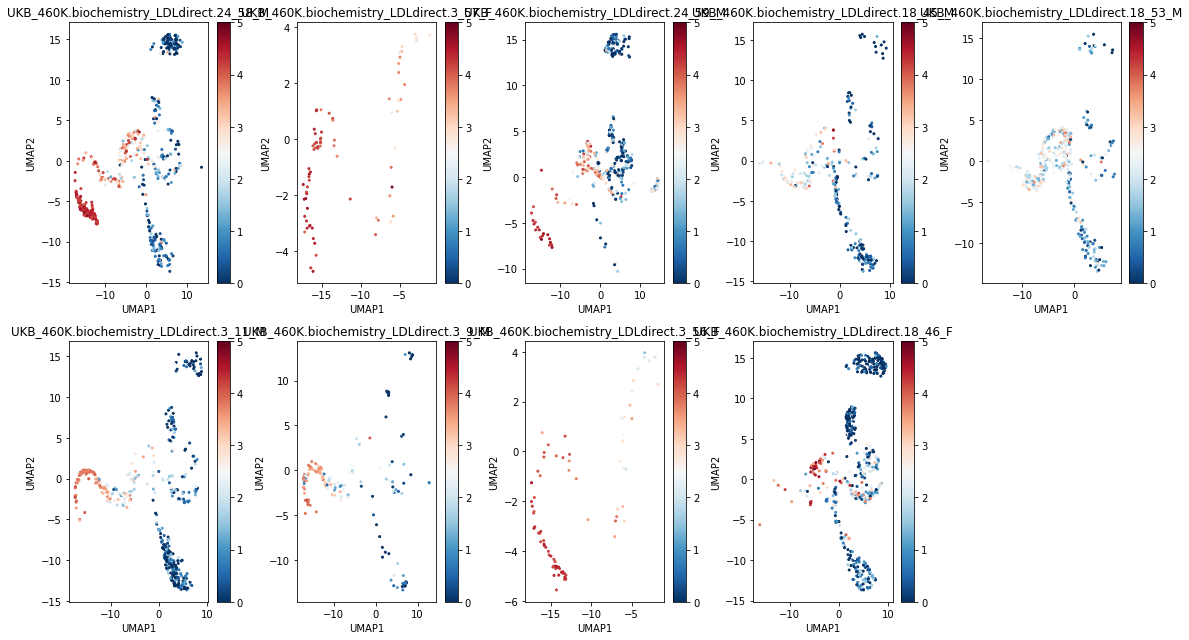

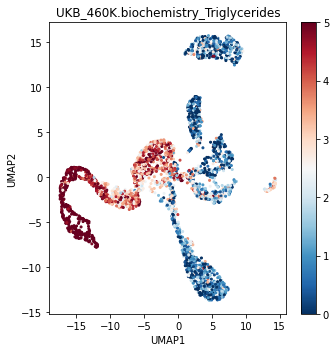

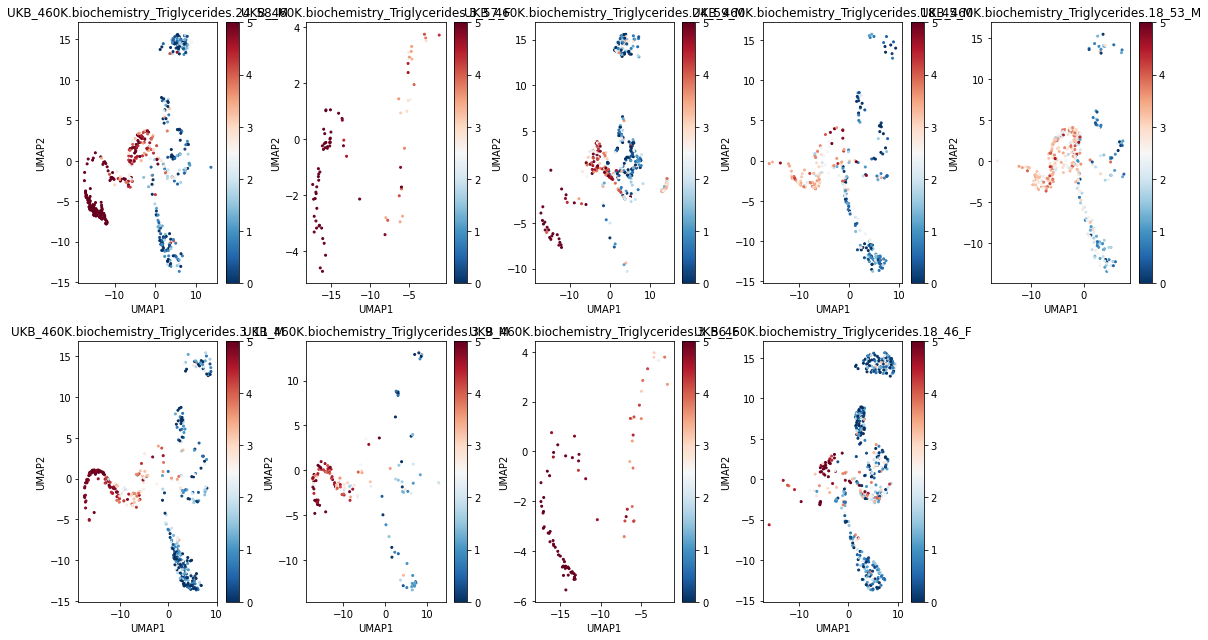

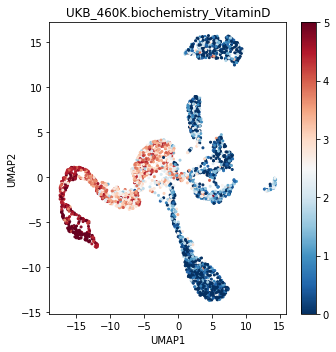

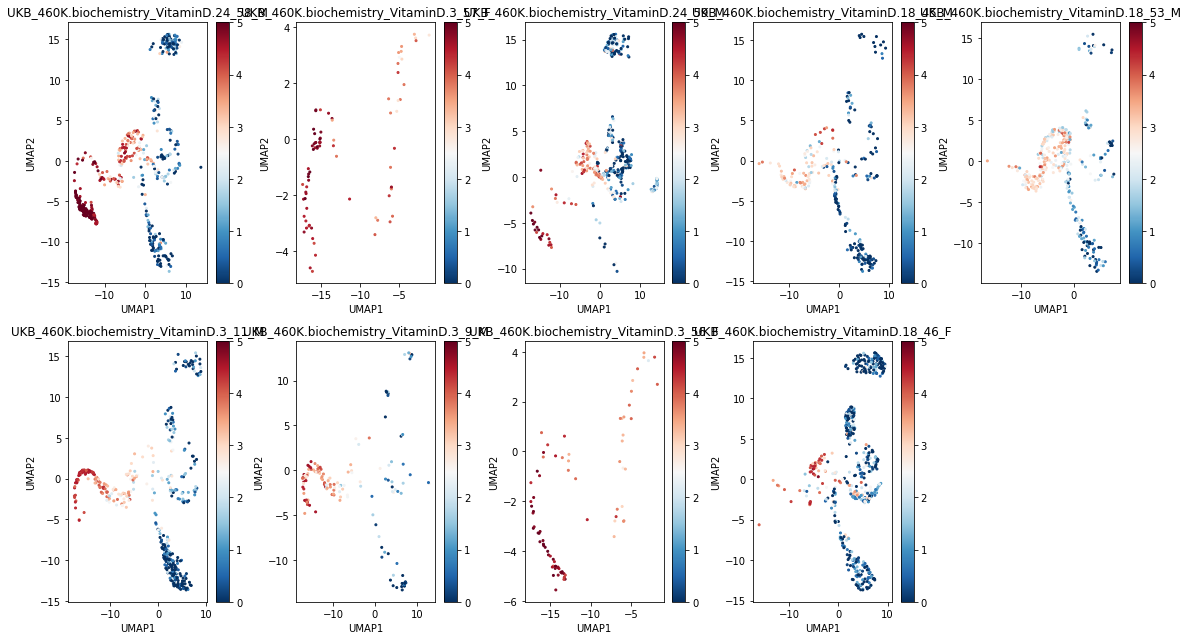

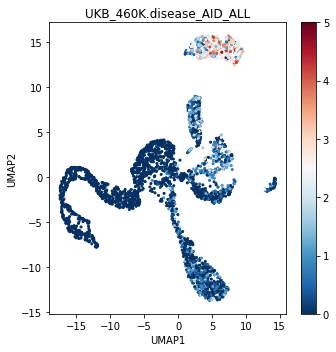

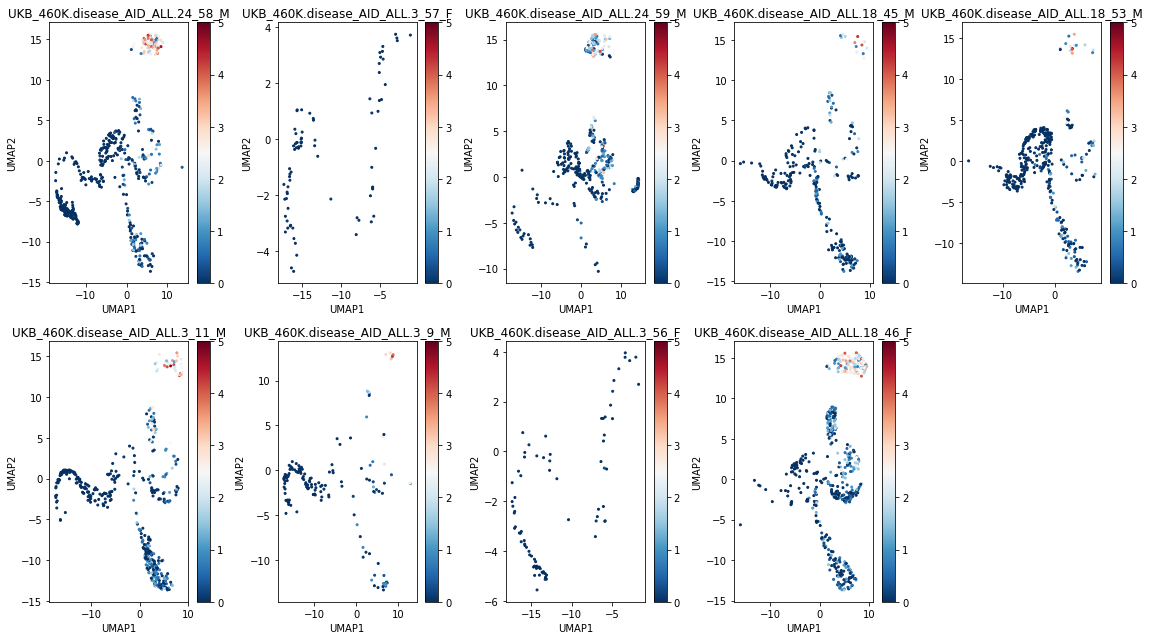

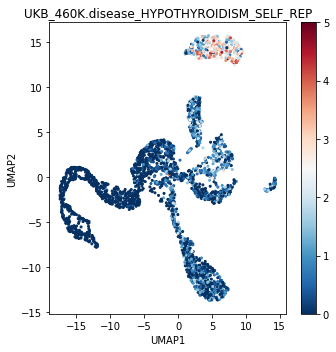

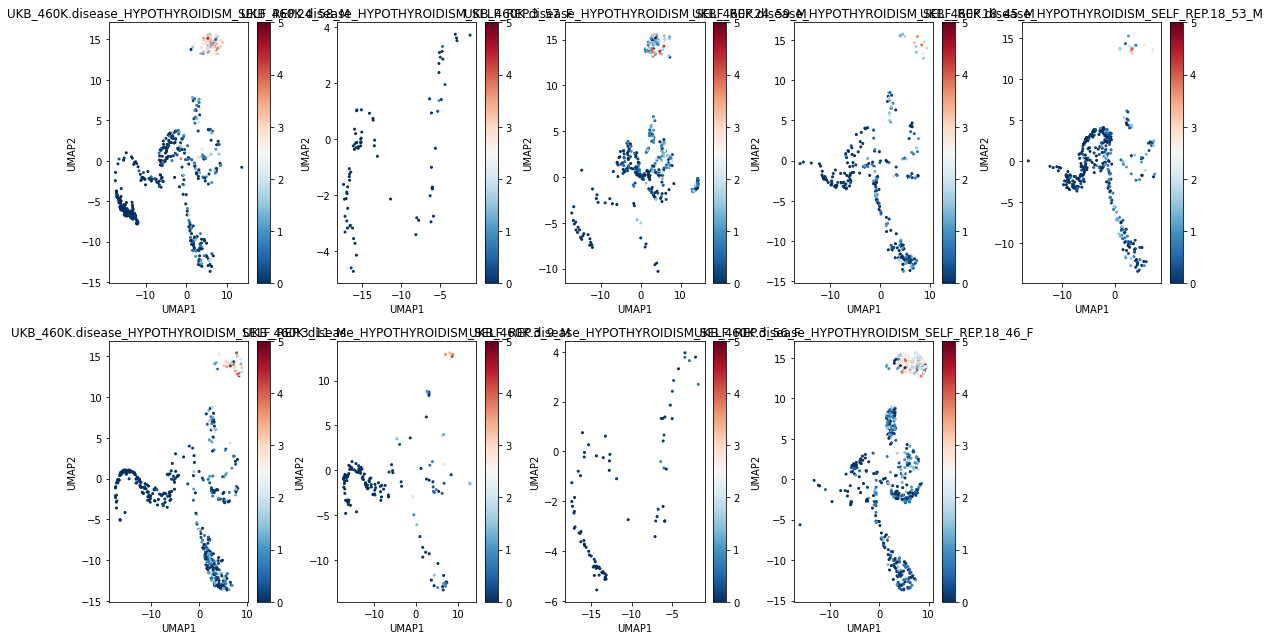

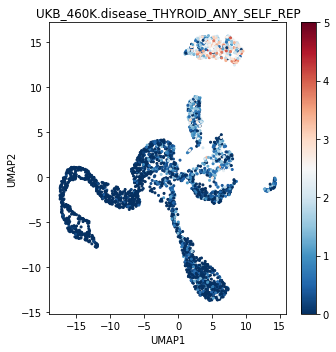

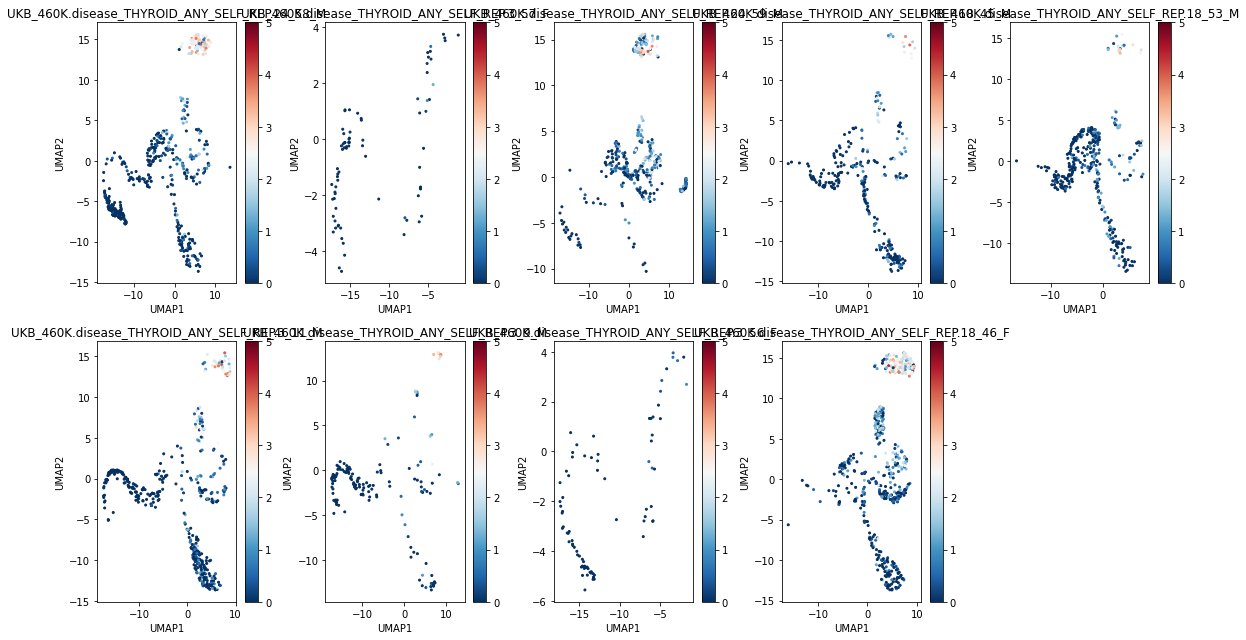

In [27]:
for trait in trait_plot_list:
    df_plot = pd.DataFrame(index=cell_list,
                           data={'UMAP1':dic_data_facs[tissue].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_facs[tissue].obsm['X_umap'][:,1],
                                 'zsc':df_score.loc[cell_list, '%s.zscore'%trait].values})
    df_plot = df_plot.join(dic_data_facs[tissue].obs)
    
    plt.figure(figsize=[5,5])
    max_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.99)
    min_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.01)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['zsc'],
                cmap='RdBu_r', vmax=5, vmin=0, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%trait)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=[16,9])
    for i_mouse,mouse_id in enumerate(set(dic_data_facs[tissue].obs['mouse.id'])):
        
        plt.subplot(2,5,i_mouse+1)
        max_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.99)
        min_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.01)
        plt.scatter(df_plot.loc[df_plot['mouse.id']==mouse_id, 'UMAP1'],
                    df_plot.loc[df_plot['mouse.id']==mouse_id, 'UMAP2'], 
                    c=df_plot.loc[df_plot['mouse.id']==mouse_id, 'zsc'],
                    cmap='RdBu_r', vmax=5, vmin=0, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s.%s'%(trait, mouse_id))
    plt.tight_layout()
    plt.show()

In [91]:
df_cell=pd.DataFrame(index=cell_list,
                     data={x: df_score.loc[cell_list, '%s.fdr'%x].values<0.05
                           for x in trait_plot_list})
adata_small=dic_data_facs[tissue].copy()
adata_small.obs = adata_small.obs.join(df_cell)

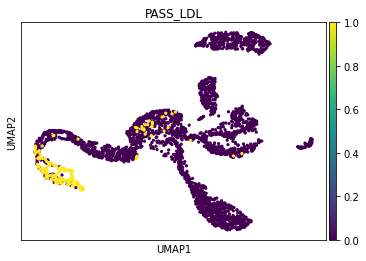

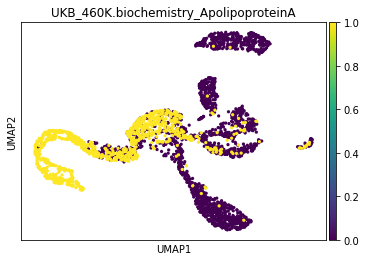

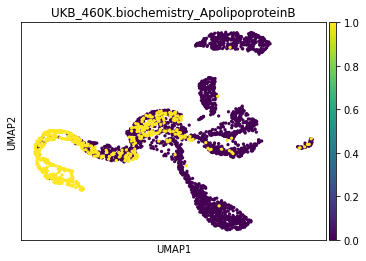

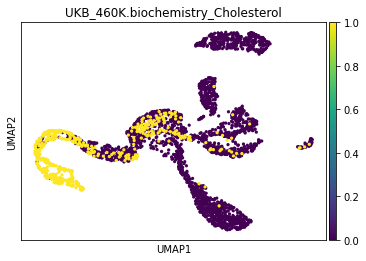

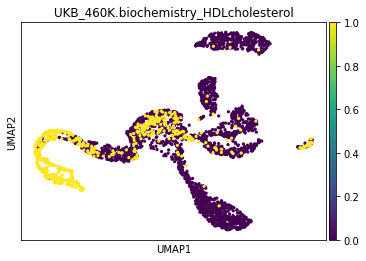

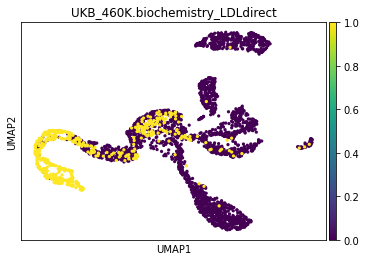

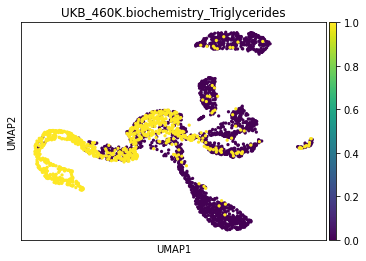

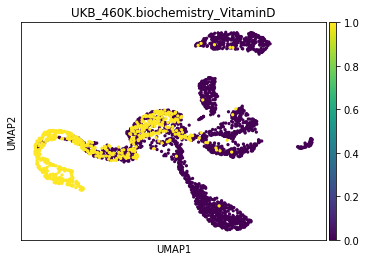

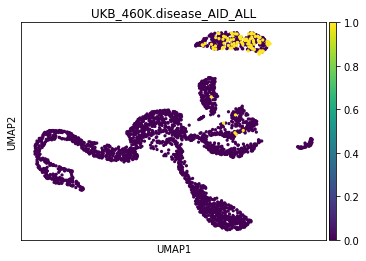

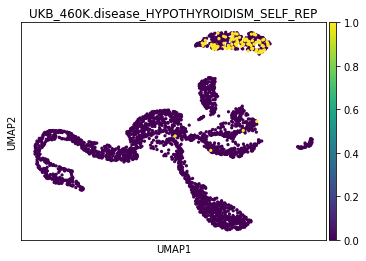

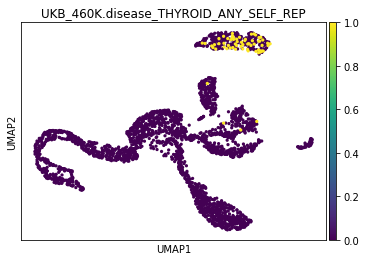

In [92]:
for trait in trait_plot_list:
    sc.pl.umap(adata_small, color=trait)

In [96]:
trait_plot_list

['PASS_LDL',
 'UKB_460K.biochemistry_ApolipoproteinA',
 'UKB_460K.biochemistry_ApolipoproteinB',
 'UKB_460K.biochemistry_Cholesterol',
 'UKB_460K.biochemistry_HDLcholesterol',
 'UKB_460K.biochemistry_LDLdirect',
 'UKB_460K.biochemistry_Triglycerides',
 'UKB_460K.biochemistry_VitaminD',
 'UKB_460K.disease_AID_ALL',
 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
 'UKB_460K.disease_THYROID_ANY_SELF_REP']

... storing 'tissue_celltype' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


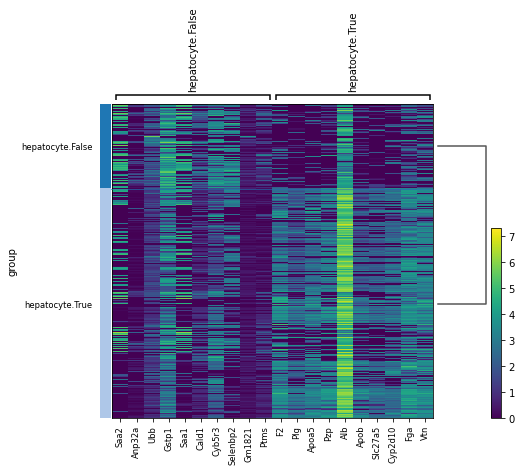

In [97]:
trait='UKB_460K.biochemistry_Triglycerides'

adata_small=data_facs_ct[(data_facs_ct.obs["tissue_celltype"]=='Liver.hepatocyte')].copy()
adata_small.obs = adata_small.obs.join(df_cell)

adata_small.obs['group'] = ['%s.%s'%(x,y) if x=='hepatocyte' else 'other'
                            for x,y in zip(adata_small.obs['cell_ontology_class'], adata_small.obs[trait])]
adata_small.obs['group'] = adata_small.obs['group'].astype('category')
sc.tl.rank_genes_groups(adata_small, groupby='group', method='t-test_overestim_var')
sc.pl.rank_genes_groups_heatmap(adata_small)

... storing 'tissue_celltype' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


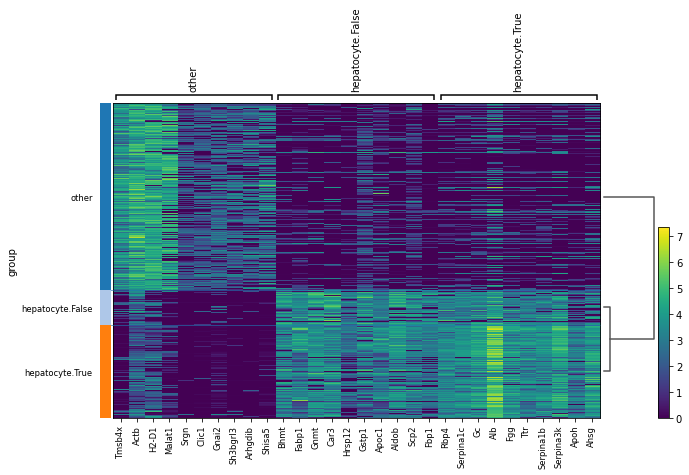

In [121]:
trait='UKB_460K.biochemistry_Triglycerides'

adata_small=data_facs_ct[(data_facs_ct.obs["tissue"]=='Liver')].copy()
adata_small.obs = adata_small.obs.join(df_cell)

adata_small.obs['group'] = ['%s.%s'%(x,y) if x=='hepatocyte' else 'other'
                            for x,y in zip(adata_small.obs['cell_ontology_class'], adata_small.obs[trait])]
adata_small.obs['group'] = adata_small.obs['group'].astype('category')
sc.tl.rank_genes_groups(adata_small, groupby='group', method='t-test_overestim_var')
sc.pl.rank_genes_groups_heatmap(adata_small)

In [122]:
from gprofiler import GProfiler
dic_pathway = {}
for term in adata_small.obs['group'].cat.categories:
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism='mmusculus', 
                            query=list(adata_small.uns['rank_genes_groups']['names'][term]),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(data_facs_ct.var_names))
    dic_pathway[term] = df_pathway.copy()
    print(term)

hepatocyte.False
hepatocyte.True
other


In [ ]:
adata_small.obs.

In [111]:
for term in adata_small.obs['group'].cat.categories:
    ind_select = 
    print(dic_pathway[term])

  source      native                                    name   p_value  \
0   KEGG  KEGG:00000                          KEGG root term  0.000466   
1   KEGG  KEGG:05132                    Salmonella infection  0.000964   
2   KEGG  KEGG:04978                      Mineral absorption  0.001685   
3   KEGG  KEGG:05014           Amyotrophic lateral sclerosis  0.005337   
4   KEGG  KEGG:05418  Fluid shear stress and atherosclerosis  0.005337   

   significant                             description  term_size  query_size  \
0         True                          KEGG root term       8050          83   
1         True                    Salmonella infection        212          83   
2         True                      Mineral absorption         51          83   
3         True           Amyotrophic lateral sclerosis        322          83   
4         True  Fluid shear stress and atherosclerosis        141          83   

   intersection_size  effective_domain_size  precision    recall    

In [123]:
temp_df = dic_pathway['hepatocyte.False'].copy()
ind_select = (temp_df['term_size']<500) & (temp_df['term_size']>5) & (temp_df['intersection_size']>10)
temp_df.loc[ind_select]

source            native                                            name  \
6    GO:BP        GO:0044282                small molecule catabolic process   
7    GO:BP        GO:1901605              alpha-amino acid metabolic process   
8    GO:BP        GO:0016054                  organic acid catabolic process   
9    GO:BP        GO:0046395               carboxylic acid catabolic process   
12   GO:BP        GO:0006520           cellular amino acid metabolic process   
13    REAC  REAC:R-MMU-71291       Metabolism of amino acids and derivatives   
22   GO:BP        GO:1901615      organic hydroxy compound metabolic process   
24   GO:BP        GO:0006066                       alcohol metabolic process   
25   GO:BP        GO:1901606              alpha-amino acid catabolic process   
26   GO:BP        GO:0006790               sulfur compound metabolic process   
27   GO:BP        GO:0009063           cellular amino acid catabolic process   
31   GO:BP        GO:0006631                    fatty acid metabolic process   
35   GO:BP        GO:0016053               organic acid biosynthetic process   
36   GO:BP        GO:0072329           monocarboxylic acid catabolic process   
39   GO:BP        GO:0009636                     response to toxic substance   
40   GO:BP        GO:0046394            carboxylic acid biosynthetic process   
41   GO:BP        GO:0044242                cellular lipid catabolic process   
45   GO:BP        GO:1901361       organic cyclic compound catabolic process   
50   GO:BP        GO:0030258                              lipid modification   
51   GO:BP        GO:0072521    purine-containing compound metabolic process   
56   GO:BP        GO:0019439             aromatic compound catabolic process   
67   GO:BP        GO:0016042                         lipid catabolic process   
71   GO:BP        GO:0008202                       steroid metabolic process   
85   GO:BP        GO:0043434                     response to peptide hormone   
91   GO:BP        GO:0010038                           response to metal ion   
101  GO:BP        GO:0006091  generation of precursor metabolites and energy   
109  GO:BP        GO:0009117                    nucleotide metabolic process   
113  GO:BP        GO:0006753          nucleoside phosphate metabolic process   
120  GO:BP        GO:0042493                                response to drug   

          p_value  significant  \
6    1.428703e-23         True   
7    9.483785e-21         True   
8    2.458972e-20         True   
9    2.458972e-20         True   
12   9.699729e-20         True   
13   4.487286e-19         True   
22   8.380383e-14         True   
24   1.410832e-13         True   
25   1.824878e-13         True   
26   1.930058e-13         True   
27   6.376991e-13         True   
31   2.841927e-12         True   
35   1.110437e-10         True   
36   1.737449e-10         True   
39   8.305542e-10         True   
40   1.299568e-09         True   
41   3.818102e-09         True   
45   1.498985e-08         True   
50   2.966746e-08         True   
51   3.332154e-08         True   
56   4.677152e-08         True   
67   2.322894e-07         True   
71   1.169435e-06         True   
85   7.761195e-06         True   
91   1.383074e-05         True   
101  2.392749e-05         True   
109  3.522069e-05         True   
113  4.220370e-05         True   
120  7.669215e-05         True   

                                           description  term_size  query_size  \
6    "The chemical reactions and pathways resulting...        337          90   
7    "The chemical reactions and pathways involving...        182          90   
8    "The chemical reactions and pathways resulting...        229          90   
9    "The chemical reactions and pathways resulting...        229          90   
12   "The chemical reactions and pathways involving...        248          90   
13           Metabolism of amino acids and derivatives        233          90   
22   "The chemi

In [124]:
temp_df = dic_pathway['hepatocyte.True'].copy()
ind_select = (temp_df['term_size']<500) & (temp_df['term_size']>5) & (temp_df['intersection_size']>10)
temp_df.loc[ind_select]

source              native  \
0     KEGG          KEGG:04610   
1    GO:BP          GO:0010951   
2    GO:BP          GO:0051346   
3    GO:BP          GO:0010466   
4     REAC    REAC:R-MMU-76005   
5     REAC   REAC:R-MMU-114608   
6    GO:BP          GO:0045861   
10    REAC   REAC:R-MMU-166658   
14   GO:BP          GO:0052548   
17   GO:BP          GO:0052547   
19   GO:BP          GO:0008202   
20   GO:BP          GO:0006639   
21    REAC    REAC:R-MMU-76002   
22   GO:BP          GO:0006638   
23   GO:BP          GO:0010876   
25    REAC  REAC:R-MMU-8957275   
28    REAC   REAC:R-MMU-381426   
33   GO:BP          GO:0006641   
35   GO:BP          GO:0030193   
36   GO:BP          GO:1900046   
37   GO:BP          GO:0050818   
38    REAC   REAC:R-MMU-109582   
43   GO:BP          GO:0007596   
44   GO:BP          GO:0007599   
45   GO:BP          GO:0050817   
48   GO:BP          GO:0006869   
54   GO:BP          GO:1901615   
55   GO:BP          GO:0046486   
56   GO:BP          GO:0008203   
57   GO:BP          GO:0006959   
58   GO:BP          GO:0016125   
59   GO:BP          GO:0006066   
61   GO:BP          GO:1902652   
63   GO:BP          GO:0061041   
66   GO:BP          GO:0050878   
68   GO:BP          GO:1905952   
72   GO:BP          GO:0019216   
74   GO:BP          GO:0016042   
84   GO:BP          GO:0045834   
85   GO:BP          GO:1903034   
92   GO:BP          GO:0042060   
102  GO:BP          GO:0044242   
108  GO:BP          GO:0044282   
110  GO:BP          GO:0009611   
119  GO:BP          GO:0032102   
123  GO:BP          GO:0015850   
124  GO:BP          GO:0006631   
128  GO:BP          GO:0015711   
177  GO:BP          GO:0002250   
178  GO:BP          GO:0010038   
202  GO:BP          GO:0043434   
231  GO:BP          GO:0042493   

                                                  name       p_value  \
0                  Complement and coagulation cascades  3.542918e-31   
1        negative regulation of endopeptidase activity  6.251815e-18   
2            negative regulation of hydrolase activity  6.251815e-18   
3            negative regulation of peptidase activity  9.311394e-18   
4         Response to elevated platelet cytosolic Ca2+  1.016499e-16   
5                              Platelet degranulation   1.016499e-16   
6                   negative regulation of proteolysis  1.859037e-16   
10                                  Complement cascade  8.355341e-15   
14                regulation of endopeptidase activity  3.811144e-14   
17                    regulation of peptidase activity  1.103822e-13   
19                           steroid metabolic process  1.103822e-13   
20                      acylglycerol metabolic process  1.509696e-13   
21      Platelet activation, signaling and aggregation  1.618631e-13   
22                     neutral lipid metabolic process  1.747859e-13   
23                                  lipid localization  5.563257e-13   
25          Post-translational protein phosphorylation  8.819061e-13   
28   Regulation of Insulin-like Growth Factor (IGF)...  1.365981e-12   
33                      triglyceride metabolic process  3.694272e-12   
35                     regulation of blood coagulation  4.264260e-12   
36                            regulation of hemostasis  4.746395e-12   
37                           regulation of coagulation  6.087963e-12   
38                                          Hemostasis  6.192655e-12   
43                                   blood coagulation  2.290252e-11   
44                                          hemostasis  2.602747e-11   
45                                         coagulation  2.647428e-11   
48                                     lipid transport  4.870587e-11   
54          organic hydroxy compound metabolic process  3.223898e-10   
55                      glycerolipid metabolic process  3.223898e-10   
56                       cholesterol metabolic process  5.107893e-10   
57                             humoral im

In [59]:
adata_small.obs[trait]

index
A10_B000767_B009945_S10.mm10-plus-4-0    False
A10_D045313_B009942_S10.mm10-plus-4-0    False
A11_B000767_B009945_S11.mm10-plus-4-0    False
A11_B001247_B009941_S11.mm10-plus-4-0    False
A11_B002688_B009944_S11.mm10-plus-4-0    False
                                         ...  
P5.MAA000907.3_11_M.1.1-1-1              False
P6.MAA000907.3_11_M.1.1-1-1              False
P7.MAA000907.3_11_M.1.1-1-1              False
P8.MAA000907.3_11_M.1.1-1-1              False
P9.MAA000907.3_11_M.1.1-1-1              False
Name: PASS_LDL, Length: 2859, dtype: category
Categories (2, object): [False, True]

In [55]:
adata_small.uns['rank_genes_groups']['params']

{'groupby': 'PASS_LDL',
 'reference': 'rest',
 'method': 't-test_overestim_var',
 'use_raw': True,
 'layer': None,
 'corr_method': 'benjamini-hochberg'}